In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pyrootutils

root = pyrootutils.setup_root(
    search_from=os.getcwd(),
    indicator=".project-root",
    pythonpath=True,
    dotenv=True,
)

In [3]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib notebook

import hydra.utils
import darts.utils.statistics
import darts.dataprocessing.encoders
import src.utils
import src.utils.plotting
import pandas as pd
import numpy as np

# Configuration

In [36]:
config_path = os.path.join("..", "..", "configs", "train.yaml") # NB: relative to <project_root>/src/utils (must be relative path)

config_overrides_dot = [# same notation as for cli overrides (dot notation). Useful for changing whole modules, e.g. change which datamodule file is loaded
    "datamodule=electricity",
    #"datamodule.dataset_name=ETTh1",
    #"++datamodule.chunk_idx=3",
    "extras.enforce_tags=false",  # these two are required for now
    "extras.print_config=null",
]
config_overrides_dict = dict()                                  # Dictionary with overrides. Useful for larger changes/additions/deletions that does not exist as entire files.

cfg = src.utils.initialize_hydra(config_path, config_overrides_dot, config_overrides_dict, return_hydra_config=True, print_config=False)  # print config to inspect if all settings are as expected

show_encoders = False

In [37]:
datamodule = hydra.utils.instantiate(cfg.datamodule, _convert_="partial")
datamodule.setup("fit")

if show_encoders and cfg.model.get("add_encoders") is not None:
    encoders = darts.dataprocessing.encoders.SequentialEncoder(hydra.utils.instantiate(cfg.model.add_encoders), takes_past_covariates=True, takes_future_covariates=True)
else:
    encoders = None

# Data Exploration

## Plot datasets (values vs time)

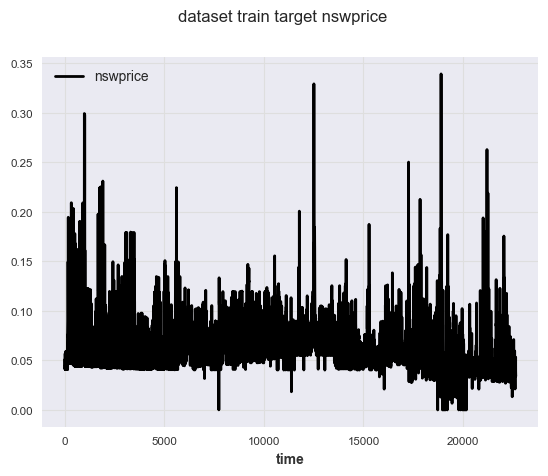

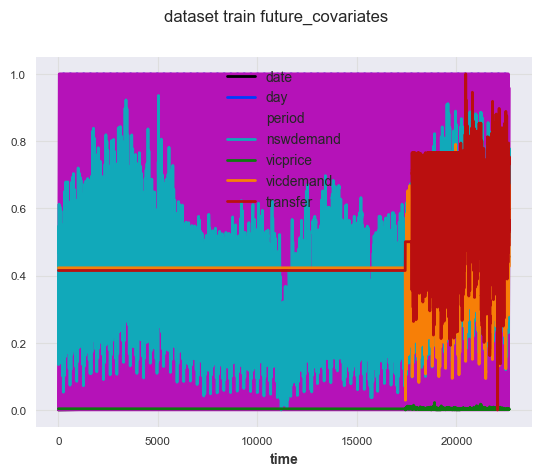

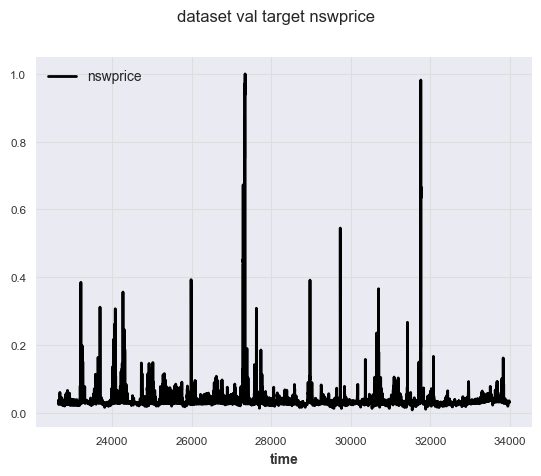

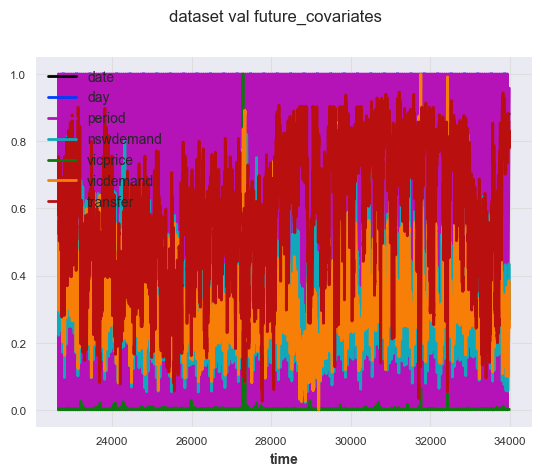

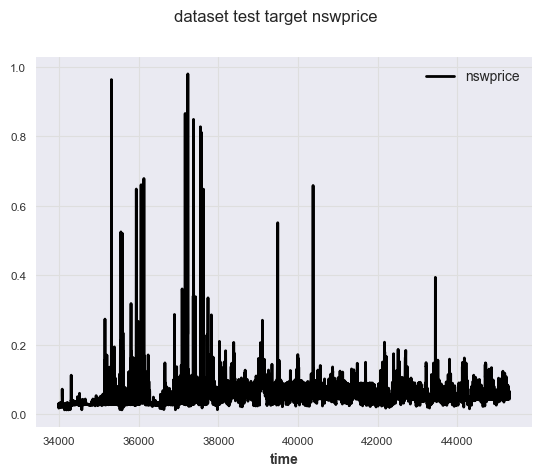

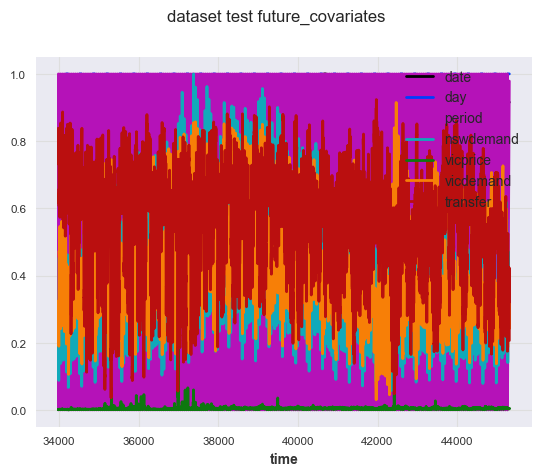

In [38]:
# If slice = None, plot all data. If slice is not None, only plot data within (start_time, end_time)
slice = None # (pd.Timestamp("1966"), pd.Timestamp("1975")) # None
_ = datamodule.plot_data(presenter="show", slice=slice)

if show_encoders and encoders is not None:
    for split in ["train", "val", "test"]:
        split_data = datamodule.get_data(["target"], main_split="train")
        if split_data is None:
            continue
        past_cov, future_cov = encoders.encode_train(target=split_data["target"])
        for cov_name, cov in zip(["past", "future"], [past_cov, future_cov]):
            if cov is None:
                continue
            fig, axs = src.utils.plotting.create_figure(1, 1)
            plt.sca(axs[0])
            cov.plot()
            plt.title(f"dataset {split} encoding: {cov_name} covariate")
            src.utils.plotting.present_figure(fig, "show")

## Seasonality
Seasonality (or autocorrelation) is the correlation of a timeseries with its past self. Weather will for instance follow yearly trends, being hotter in the summer and colder in the winter, and a seasons' temperature for the previous year will therefore  correlate with the seasons' next year's temperature. The following code aids in identifying if the data is seasonal, and if so with what frequency. Note that if the autocorrelation plot shows a high but linearly (ish) decaying trend then this can indicate that your data is essentially a random-walk. The blue shaded region corresponds to a confidence interval of (1 - alpha), i.e. with the default alpha = 0.05 we can be 95 % sure that the autocorrelation is real and not due to noise if the height of the bar at that lag is outside the blue shaded region.



In [21]:
series_to_plot = {"train": {"target": "all"}}
#series_to_plot = {"train": {"past_covariates": "all"}}
max_lag = 100
highlight_lag = 48

seasonality_plot_func = lambda ts: darts.utils.statistics.plot_acf(ts, max_lag=max_lag, m=highlight_lag, alpha=0.05, fig_size=(10, 5))  # auto-correlation function
seasonality_partial_plot_func = lambda ts: darts.utils.statistics.plot_pacf(ts, m=highlight_lag, max_lag=max_lag, alpha=0.05, fig_size=(10, 5))  # partial auto-correlation function
seasonality_check_func = lambda ts: darts.utils.statistics.check_seasonality(ts, m=highlight_lag, max_lag=max_lag, alpha=0.05)

In [22]:
datamodule.call_function_on_univariate_series(seasonality_check_func, series_to_plot)

{'train': {'target': {'nswprice': (True, 48)}}}

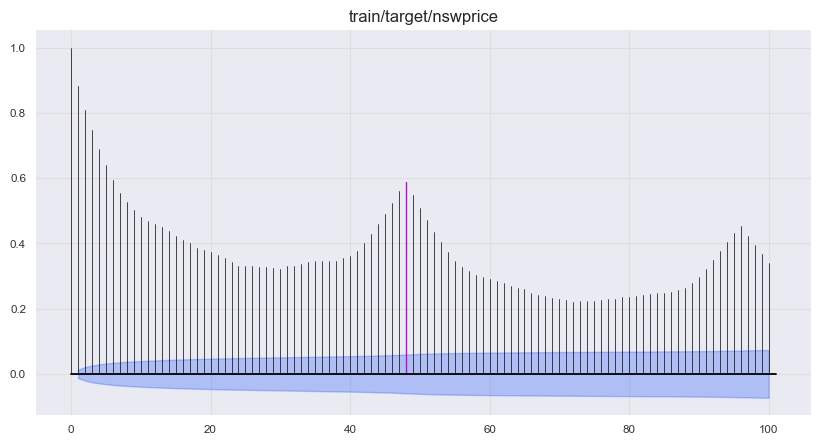

In [23]:
_ = datamodule.call_function_on_univariate_series(seasonality_plot_func, series_to_plot, presenter="show")

### Partial Autocorrelation
TODO: Define

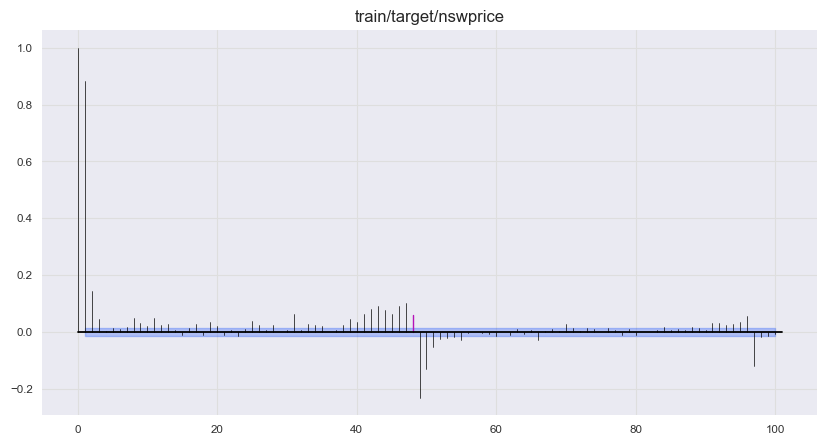

In [24]:
_ = datamodule.call_function_on_univariate_series(seasonality_partial_plot_func, series_to_plot, presenter="show")

### Seasonal Decomposition

In [ ]:
stl_trend_plot_func = lambda ts: darts.utils.statistics.extract_trend_and_seasonality(ts, model=darts.utils.utils.SeasonalityMode("additive"), freq=4, method="STL")  # returns Tuple[trend, season]
stl_res = datamodule.call_function_on_univariate_series(stl_trend_plot_func, series_to_plot)

In [ ]:
for split in stl_res:
    for data_type in stl_res[split]:
        for component_name, data in stl_res[split][data_type].items():
            src.utils.plotting.plot_darts_timeseries(data[0], title=f"Trend for {split}/{data_type}/{component_name}", presenter="show")
            src.utils.plotting.plot_darts_timeseries(data[1], title=f"Season for {split}/{data_type}/{component_name}", presenter="show")

## Histogram

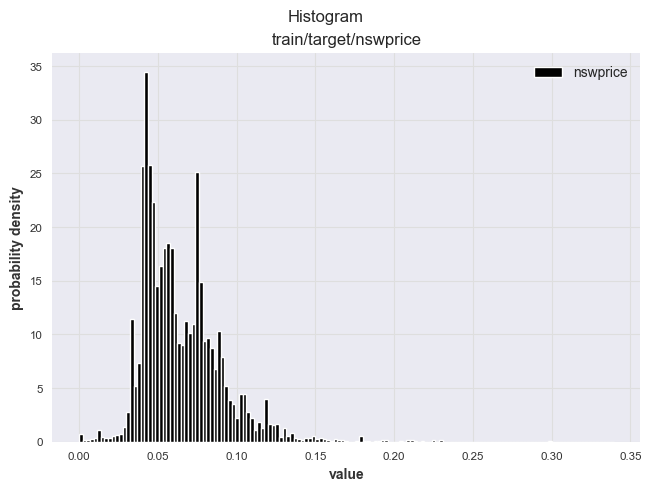

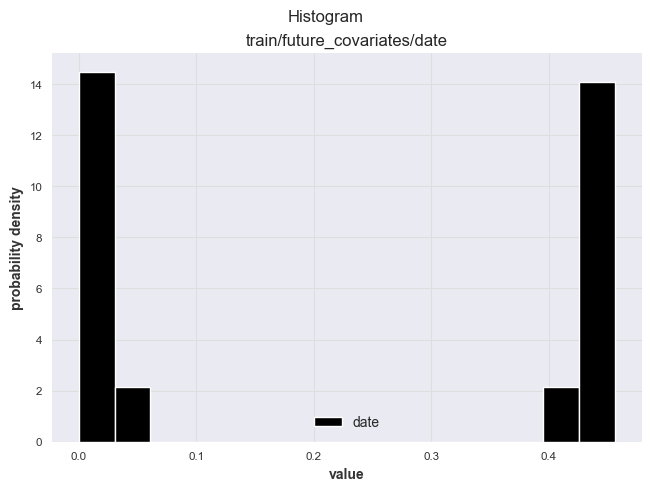

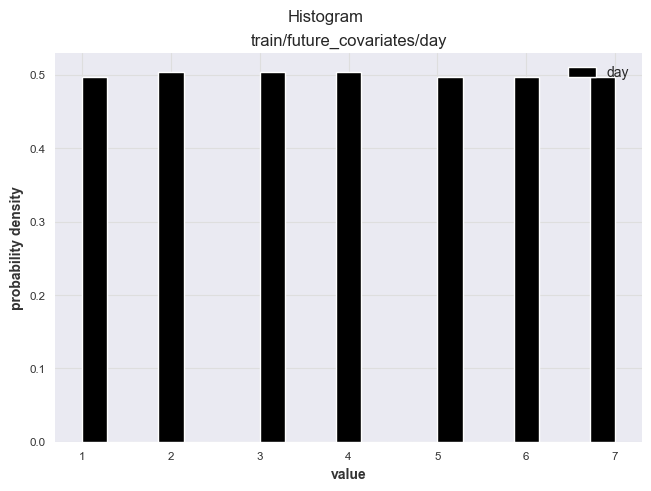

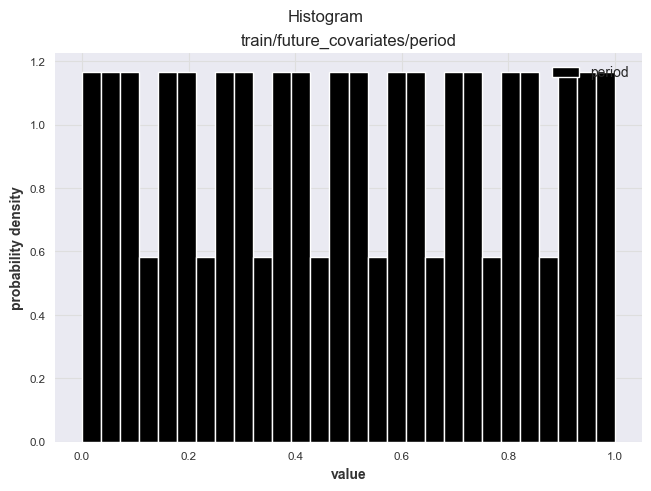

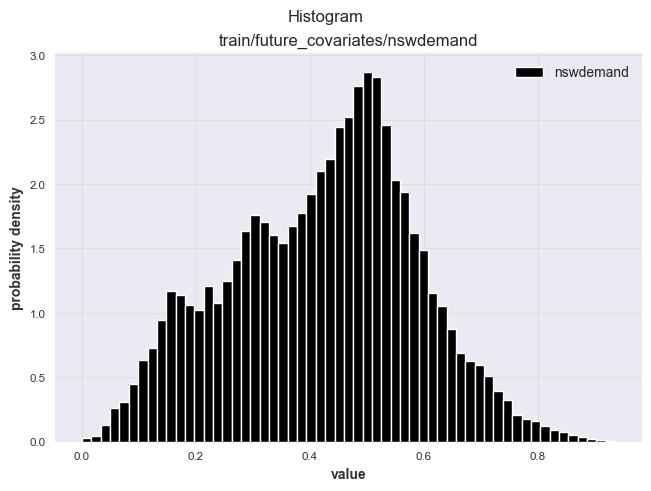

ValueError: Cannot calculate number of bins given data x (q25: 0.00, q75: 0.00, bin_width: 0.00, any_nans: False)

In [13]:
series_to_plot = "all" #{"test": {"actual_anomalies": "all"}}
seasonality_plot_func = lambda ts: darts.utils.statistics.plot_hist(ts, bins=src.utils.hist_bin_num_freedman_diaconis(ts), density=True)
_ = datamodule.call_function_on_univariate_series(seasonality_plot_func, series_to_plot, presenter="show")

## Stationarity

In [ ]:
series_to_check = "all"
adf_test_func = lambda ts: darts.utils.statistics.stationarity_test_adf(ts, maxlag=None, regression="c", autolag="AIC")  # Augmented Dickey-Fuller unit root test for a time series
datamodule.call_function_on_univariate_series(adf_test_func, series_to_check)

## Feature Correlation

In [17]:
df = datamodule.data.pd_dataframe()

if show_encoders and encoders is not None:
    for cov in encoders.encode_train(target=datamodule.data):
        if cov is None:
            continue
        df = pd.merge(df, cov.pd_dataframe(), left_index=True, right_index=True)

corr = df.corr()

# make correlation matrix upper triangular as it is symmetric
corr = corr.where(np.triu(np.ones(corr.shape)).astype(bool))

corr.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1).format(precision=2)

component,nswprice,date,day,period,nswdemand,vicprice,vicdemand,transfer
component,,,,,,,,
nswprice,1.00,-0.15,0.00,0.10,0.30,0.29,0.31,-0.28
date,nan,1.00,0.00,-0.00,0.07,0.00,0.06,0.41
day,nan,nan,1.00,-0.00,-0.05,0.00,0.08,-0.06
period,nan,nan,nan,1.00,0.45,0.02,0.19,-0.12
nswdemand,nan,nan,nan,nan,1.00,0.09,0.67,-0.27
vicprice,nan,nan,nan,nan,nan,1.00,0.13,-0.08
vicdemand,nan,nan,nan,nan,nan,nan,1.00,-0.56
transfer,nan,nan,nan,nan,nan,nan,nan,1.00


In [20]:
corr

component,nswprice,date,day,period,nswdemand,vicprice,vicdemand,transfer
component,,,,,,,,
nswprice,1.0,-0.151428,0.003292,1.041553e-01,0.304952,0.286072,0.307275,-0.275001
date,NaN,1.000000,0.004846,-4.194514e-15,0.066748,0.003225,0.055323,0.405012
day,NaN,NaN,1.000000,-1.150400e-17,-0.052672,0.000123,0.077716,-0.056159
period,NaN,NaN,NaN,1.000000e+00,0.445547,0.023245,0.192945,-0.116979
nswdemand,NaN,NaN,NaN,NaN,1.000000,0.086393,0.668501,-0.267897
vicprice,NaN,NaN,NaN,NaN,NaN,1.000000,0.127553,-0.084166
vicdemand,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.555525
transfer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


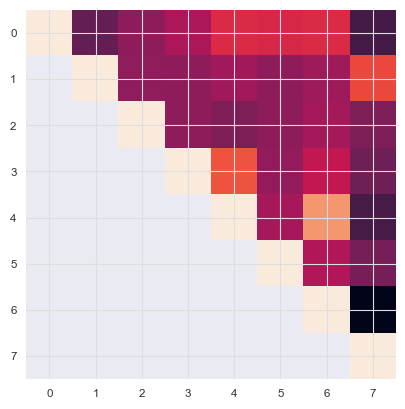

In [19]:
plt.imshow(corr)